In [1]:
# ORIGINAL  https://pennylane.ai/qml/demos/tutorial_kernels_module/
%matplotlib inline

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


Training and evaluating quantum kernels
=======================================

::: {.meta}
:property=\"og:description\": Kernels and alignment training with
Pennylane. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//QEK_thumbnail.png>
:::

::: {.related}
tutorial\_kernel\_based\_training Kernel-based training with
scikit-learn tutorial\_data\_reuploading\_classifier Data-reuploading
classifier
:::

*Authors: Peter-Jan Derks, Paul K. Faehrmann, Elies Gil-Fuster, Tom
Hubregtsen, Johannes Jakob Meyer and David Wierichs --- Posted: 24 June
2021. Last updated: 18 November 2021.*

Kernel methods are one of the cornerstones of classical machine
learning. Here we are concerned with kernels that can be evaluated on
quantum computers, *quantum kernels* for short. In this tutorial you
will learn how to evaluate kernels, use them for classification and
train them with gradient-based optimization, and all that using the
functionality of PennyLane\'s [kernels
module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html).
The demo is based on Ref., a project from Xanadu\'s own
[QHack](https://qhack.ai/) hackathon.

What are kernel methods?
------------------------

To understand what a kernel method does, let\'s first revisit one of the
simplest methods to assign binary labels to datapoints: linear
classification.

Imagine we want to discern two different classes of points that lie in
different corners of the plane. A linear classifier corresponds to
drawing a line and assigning different labels to the regions on opposing
sides of the line:

![](../_static/demonstration_assets/kernels_module/linear_classification.png){.align-center
width="30.0%"}

We can mathematically formalize this by assigning the label $y$ via

$$y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \boldsymbol{x}\rangle + b).$$

The vector $\boldsymbol{w}$ points perpendicular to the line and thus
determine its slope. The independent term $b$ specifies the position on
the plane. In this form, linear classification can also be extended to
higher dimensional vectors $\boldsymbol{x}$, where a line does not
divide the entire space into two regions anymore. Instead one needs a
*hyperplane*. It is immediately clear that this method is not very
powerful, as datasets that are not separable by a hyperplane can\'t be
classified without error.

We can actually sneak around this limitation by performing a neat trick:
if we define some map $\phi(\boldsymbol{x})$ that *embeds* our
datapoints into a larger *feature space* and then perform linear
classification there, we could actually realise non-linear
classification in our original space!

![](../_static/demonstration_assets/kernels_module/embedding_nonlinear_classification.png){.align-center
width="65.0%"}

If we go back to the expression for our prediction and include the
embedding, we get

$$y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \phi(\boldsymbol{x})\rangle + b).$$

We will forgo one tiny step, but it can be shown that for the purpose of
optimal classification, we can choose the vector defining the decision
boundary as a linear combination of the embedded datapoints
$\boldsymbol{w} = \sum_i \alpha_i \phi(\boldsymbol{x}_i)$. Putting this
into the formula yields

$$y(\boldsymbol{x}) = \operatorname{sgn}\left(\sum_i \alpha_i \langle \phi(\boldsymbol{x}_i), \phi(\boldsymbol{x})\rangle + b\right).$$

This rewriting might not seem useful at first, but notice the above
formula only contains inner products between vectors in the embedding
space:

$$k(\boldsymbol{x}_i, \boldsymbol{x}_j) = \langle \phi(\boldsymbol{x}_i), \phi(\boldsymbol{x}_j)\rangle.$$

We call this function the *kernel*. It provides the advantage that we
can often find an explicit formula for the kernel $k$ that makes it
superfluous to actually perform the (potentially expensive) embedding
$\phi$. Consider for example the following embedding and the associated
kernel:

$$\begin{aligned}
\phi((x_1, x_2)) &= (x_1^2, \sqrt{2} x_1 x_2, x_2^2) \\
k(\boldsymbol{x}, \boldsymbol{y}) &= x_1^2 y_1^2 + 2 x_1 x_2 y_1 y_2 + x_2^2 y_2^2 = \langle \boldsymbol{x}, \boldsymbol{y} \rangle^2.
\end{aligned}$$

This means by just replacing the regular scalar product in our linear
classification with the map $k$, we can actually express much more
intricate decision boundaries!

This is very important, because in many interesting cases the embedding
$\phi$ will be much costlier to compute than the kernel $k$.

In this demo, we will explore one particular kind of kernel that can be
realized on near-term quantum computers, namely *Quantum Embedding
Kernels (QEKs)*. These are kernels that arise from embedding data into
the space of quantum states. We formalize this by considering a
parameterised quantum circuit $U(\boldsymbol{x})$ that maps a datapoint
$\boldsymbol{x}$ to the state

$$|\psi(\boldsymbol{x})\rangle = U(\boldsymbol{x}) |0 \rangle.$$

The kernel value is then given by the *overlap* of the associated
embedded quantum states

$$k(\boldsymbol{x}_i, \boldsymbol{x}_j) = | \langle\psi(\boldsymbol{x}_i)|\psi(\boldsymbol{x}_j)\rangle|^2.$$


A toy problem
=============

In this demo, we will treat a toy problem that showcases the inner
workings of classification with quantum embedding kernels, training
variational embedding kernels and the available functionalities to do
both in PennyLane. We of course need to start with some imports:


In [2]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


And we proceed right away to create a dataset to work with, the
`DoubleCake` dataset. Firstly, we define two functions to enable us to
generate the data. The details of these functions are not essential for
understanding the demo, so don\'t mind them if they are confusing.


In [3]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

Next, we define a function to help plot the `DoubleCake` data:


In [4]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax

Let\'s now have a look at our dataset. In our example, we will work with
3 sectors:


shape: (6, 2) (6,)


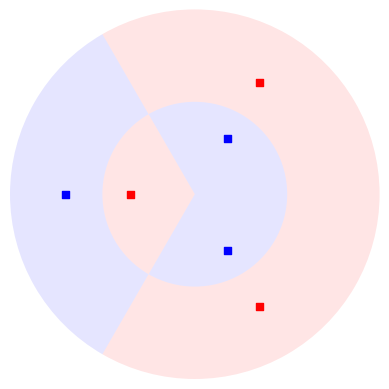

In [5]:
import matplotlib.pyplot as plt

num_sectors = 3
X, Y = make_double_cake_data(num_sectors)
print('shape:',X.shape,Y.shape)
ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

Defining a Quantum Embedding Kernel
===================================

PennyLane\'s [kernels
module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html)
allows for a particularly simple implementation of Quantum Embedding
Kernels. The first ingredient we need for this is an *ansatz*, which we
will construct by repeating a layer as building block. Let\'s start by
defining this layer:

Together with the ansatz we only need a device to run the quantum
circuit on. For the purpose of this tutorial we will use PennyLane\'s
`default.qubit` device with 5 wires in analytic mode.

In [6]:
import pennylane as qml
nwires=3
dev = qml.device("default.qubit", wires=nwires, shots=None)
wires = dev.wires.tolist()
print('wires:',wires)

wires: [0, 1, 2]


In [7]:
def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, ( num_layers, 2,num_wires), requires_grad=True)

In [38]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz
        params[0,:] define RY angle per qubit
        params[1,:] define CRC entagling angle per pair of qubit
    """
    #print('lll',x.shape,params.shape)
    #print('lll2',x,params)
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        #print('qq',j,wire,i)
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

In [51]:
def layer_empty(x, params,  wires, i0=0, inc=1):
    """Building block of the embedding ansatz
        params[0,:] define RY angle per qubit
        params[1,:] define CRC entagling angle per pair of qubit
    """
    #print('lll',x.shape,params.shape)
    #print('lll2',x,params)
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc

In [100]:
print('Display circ for a single layer')
@qml.qnode(dev)
def layer_circuit(x, params, wires):
    layer(x, params, wires=wires)
    #1layer_empty(x, params, wires=wires)
    return qml.probs(wires=wires)
par1 = random_params(num_wires=nwires, num_layers=1)
print('par1:',par1.shape)
print(qml.draw(layer_circuit)(X[0], par1[0], wires)) 

Display circ for a single layer
par1: (2, 2, 3)
0: ──H──RZ(0.35)──RY(3.23)─╭●──────────────────╭RZ(1.87)─┤ ╭Probs
1: ──H──RZ(0.61)──RY(0.98)─╰RZ(0.83)─╭●────────│─────────┤ ├Probs
2: ──H──RZ(0.35)──RY(3.71)───────────╰RZ(1.08)─╰●────────┤ ╰Probs


To construct the ansatz, this layer is repeated multiple times, reusing
the datapoint `x` but feeding different variational parameters `params`
into each of them. Together, the datapoint and the variational
parameters fully determine the embedding ansatz $U(\boldsymbol{x})$. In
order to construct the full kernel circuit, we also require its adjoint
$U(\boldsymbol{x})^\dagger$, which we can obtain via `qml.adjoint`.


In [82]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

adjoint_ansatz = qml.adjoint(ansatz)

In [101]:
print('Display circ for the ansatz')
@qml.qnode(dev)
def ansatz_circuit(x, params, wires):
    ansatz(x, params, wires=wires)
    return qml.probs(wires=wires)
par2 = random_params(num_wires=nwires, num_layers=2)
print('par2:',par2.shape)
print(qml.draw(ansatz_circuit, max_length=120)(X[0], par2, wires)) 

Display circ for the ansatz
par2: (2, 2, 3)
0: ──H──RZ(0.35)──RY(2.92)─╭●──────────────────╭RZ(5.69)──H──RZ(0.61)──RY(5.88)─╭●──────────────────╭RZ(4.00)─┤ ╭Probs
1: ──H──RZ(0.61)──RY(3.15)─╰RZ(1.81)─╭●────────│──────────H──RZ(0.35)──RY(5.00)─╰RZ(0.58)─╭●────────│─────────┤ ├Probs
2: ──H──RZ(0.35)──RY(4.61)───────────╰RZ(2.73)─╰●─────────H──RZ(0.61)──RY(0.56)───────────╰RZ(2.09)─╰●────────┤ ╰Probs


Let us now define the quantum circuit that realizes the kernel. We will
compute the overlap of the quantum states by first applying the
embedding of the first datapoint and then the adjoint of the embedding
of the second datapoint. We finally extract the probabilities of
observing each basis state.


In [84]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

In [85]:
print('Display circ for the kernel')
print('par2:',par2.shape)
print(qml.draw(kernel_circuit, max_length=120)(X[0], X[1], par2)) 

Display circ for the kernel
par2: (1, 2, 3)
0: ──H──RZ(0.35)──RY(5.39)─╭●──────────────────╭RZ(3.81)─╭RZ(3.81)†────────────╭●──────────RY(5.39)†───RZ(-0.70)†──H†─┤
1: ──H──RZ(0.61)──RY(3.04)─╰RZ(6.21)─╭●────────│─────────│──────────╭●─────────╰RZ(6.21)†──RY(3.04)†───RZ(0.00)†───H†─┤
2: ──H──RZ(0.35)──RY(1.66)───────────╰RZ(4.03)─╰●────────╰●─────────╰RZ(4.03)†──RY(1.66)†──RZ(-0.70)†──H†─────────────┤

  ╭Probs
  ├Probs
  ╰Probs


X0,X1 [0.35       0.60621778] [-7.00000000e-01  8.57252759e-17]


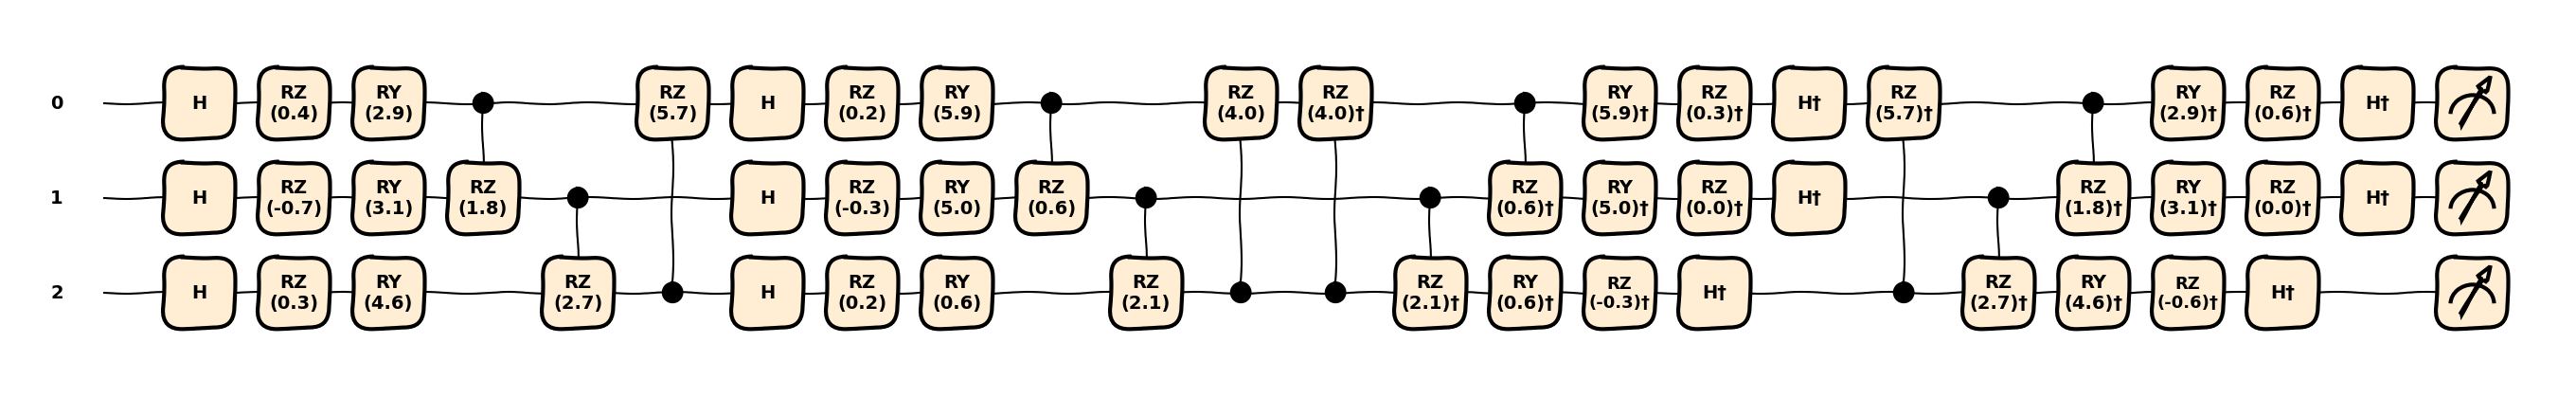

In [102]:
#comp_circuit = qml.compile( kernel_circuit, num_passes=4)
comp_circuit =qml.transforms.merge_rotations(kernel_circuit, atol=1e-8, include_gates=None)
#comp_circuit =qml.transforms.cancel_inverses(kernel_circuit)
qnode1 = qml.QNode(comp_circuit, dev)
print('X0,X1',X[0], X[1])
qml.draw_mpl(qnode1, decimals=1, style="sketch")(X[:,0], X[:,1], par2)
plt.show()

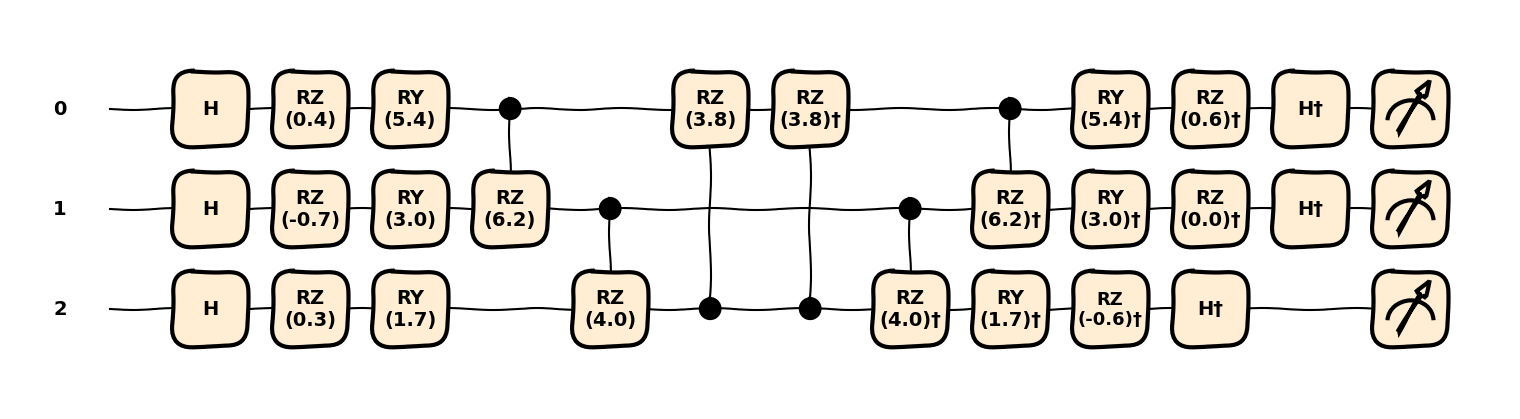

In [91]:
# set basis_set : run our circuit on a device that can only implement single-qubit rotations and CNOT operations. 
compiled_circuit = qml.compile(kernel_circuit, basis_set=["CNOT", "RX", "RY", "RZ"], num_passes=2)

qnode = qml.QNode(compiled_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(X[:,0], X[:,1], par2)
plt.show()


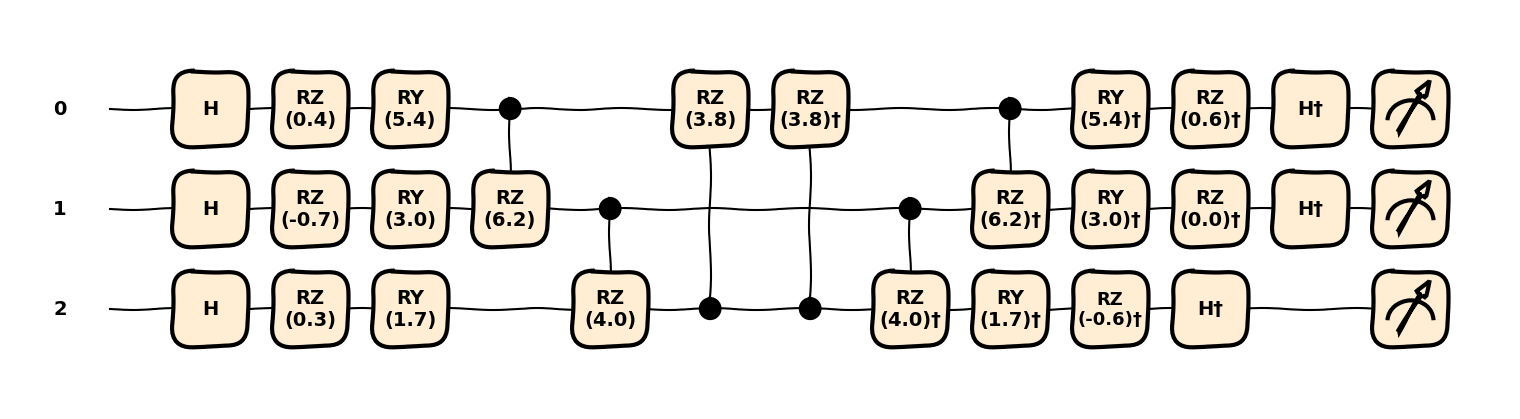

In [98]:
from functools import partial

compiled_circuit2 = qml.compile(
    kernel_circuit,
    pipeline=[
        partial(qml.transforms.commute_controlled, direction="left"),  # Opposite direction
        partial(qml.transforms.merge_rotations, atol=1e-8, include_gates=None),  # Different threshold
        qml.transforms.cancel_inverses,  # Cancel inverses after rotations
    ],
    num_passes=10,
)
qnode2 = qml.QNode(compiled_circuit2, dev)
qml.draw_mpl(qnode2, decimals=1, style="sketch")(X[:,0], X[:,1], par2)
plt.show()

The kernel function itself is now obtained by looking at the probability
of observing the all-zero state at the end of the kernel circuit --
because of the ordering in `qml.probs`, this is the first entry:


In [59]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

::: {.note}
::: {.title}
Note
:::

An alternative way to set up the kernel circuit in PennyLane would be to
use the observable type
[Projector](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.Projector.html).
This is shown in the [demo on kernel-based training of quantum
models](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html),
where you will also find more background information on the kernel
circuit structure itself.
:::

Before focusing on the kernel values we have to provide values for the
variational parameters. At this point we fix the number of layers in the
ansatz circuit to $6$.


In [60]:
init_params = random_params(num_wires=nwires, num_layers=6)

Now we can have a look at the kernel value between the first and the
second datapoint:


In [68]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.110


The mutual kernel values between all elements of the dataset form the
*kernel matrix*. We can inspect it via the
`qml.kernels.square_kernel_matrix` method, which makes use of symmetry
of the kernel,
$k(\boldsymbol{x}_i,\boldsymbol{x}_j) = k(\boldsymbol{x}_j, \boldsymbol{x}_i)$.
In addition, the option `assume_normalized_kernel=True` ensures that we
do not calculate the entries between the same datapoints, as we know
them to be 1 for our noiseless simulation. Overall this means that we
compute $\frac{1}{2}(N^2-N)$ kernel values for $N$ datapoints. To
include the variational parameters, we construct a `lambda` function
that fixes them to the values we sampled above.


In [81]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)
print('X:',X)
with np.printoptions(precision=3, suppress=True):
    print(K_init)

X: [[ 3.50000000e-01  6.06217783e-01]
 [-7.00000000e-01  8.57252759e-17]
 [ 3.50000000e-01 -6.06217783e-01]
 [ 1.75000000e-01  3.03108891e-01]
 [-3.50000000e-01  4.28626380e-17]
 [ 1.75000000e-01 -3.03108891e-01]]
[[1.    0.026 0.004 0.67  0.131 0.058]
 [0.026 1.    0.026 0.009 0.561 0.009]
 [0.004 0.026 1.    0.058 0.131 0.67 ]
 [0.67  0.009 0.058 1.    0.241 0.328]
 [0.131 0.561 0.131 0.241 1.    0.241]
 [0.058 0.009 0.67  0.328 0.241 1.   ]]


Using the Quantum Embedding Kernel for predictions
==================================================

The quantum kernel alone can not be used to make predictions on a
dataset, becaues it is essentially just a tool to measure the similarity
between two datapoints. To perform an actual prediction we will make use
of scikit-learn\'s Support Vector Classifier (SVC).


In [19]:
from sklearn.svm import SVC

To construct the SVM, we need to supply `sklearn.svm.SVC` with a
function that takes two sets of datapoints and returns the associated
kernel matrix. We can make use of the function
`qml.kernels.kernel_matrix` that provides this functionality. It expects
the kernel to not have additional parameters besides the datapoints,
which is why we again supply the variational parameters via the `lambda`
function from above. Once we have this, we can let scikit-learn adjust
the SVM from our Quantum Embedding Kernel.

::: {.note}
::: {.title}
Note
:::

This step does *not* modify the variational parameters in our circuit
ansatz. What it does is solving a different optimization task for the
$\alpha$ and $b$ vectors we introduced in the beginning.
:::


In [20]:
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

To see how well our classifier performs we will measure which percentage
of the dataset it classifies correctly.


In [21]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.667


We are also interested in seeing what the decision boundaries in this
classification look like. This could help us spotting overfitting issues
visually in more complex data sets. To this end we will introduce a
second helper method.


In [22]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

With that done, let\'s have a look at the decision boundaries for our
initial classifier:


KeyboardInterrupt: 

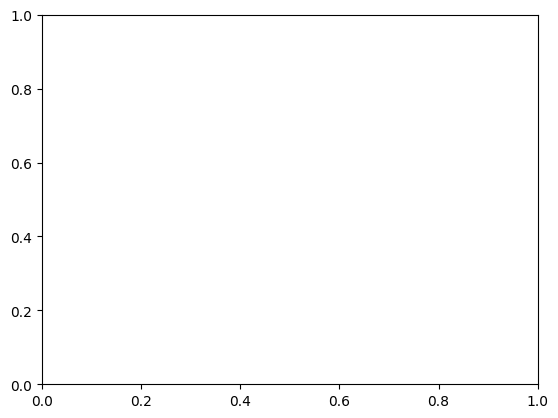

In [23]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

We see the outer points in the dataset can be correctly classified, but
we still struggle with the inner circle. But remember we have a circuit
with many free parameters! It is reasonable to believe we can give
values to those variational parameters which improve the overall
accuracy of our SVC.

Training the Quantum Embedding Kernel
=====================================

To be able to train the Quantum Embedding Kernel we need some measure of
how well it fits the dataset in question. Performing an exhaustive
search in parameter space is not a good solution because it is very
resource intensive, and since the accuracy is a discrete quantity we
would not be able to detect small improvements.

We can, however, resort to a more specialized measure, the
*kernel-target alignment*. The kernel-target alignment compares the
similarity predicted by the quantum kernel to the actual labels of the
training data. It is based on *kernel alignment*, a similiarity measure
between two kernels with given kernel matrices $K_1$ and $K_2$:

$$\operatorname{KA}(K_1, K_2) = \frac{\operatorname{Tr}(K_1 K_2)}{\sqrt{\operatorname{Tr}(K_1^2)\operatorname{Tr}(K_2^2)}}.$$

::: {.note}
::: {.title}
Note
:::

Seen from a more theoretical side, $\operatorname{KA}$ is nothing else
than the cosine of the angle between the kernel matrices $K_1$ and $K_2$
if we see them as vectors in the space of matrices with the
Hilbert-Schmidt (or Frobenius) scalar product
$\langle A, B \rangle = \operatorname{Tr}(A^T B)$. This reinforces the
geometric picture of how this measure relates to objects, namely two
kernels, being aligned in a vector space.
:::

The training data enters the picture by defining an *ideal* kernel
function that expresses the original labelling in the vector
$\boldsymbol{y}$ by assigning to two datapoints the product of the
corresponding labels:

$$k_{\boldsymbol{y}}(\boldsymbol{x}_i, \boldsymbol{x}_j) = y_i y_j.$$

The assigned kernel is thus $+1$ if both datapoints lie in the same
class and $-1$ otherwise and its kernel matrix is simply given by the
outer product $\boldsymbol{y}\boldsymbol{y}^T$. The kernel-target
alignment is then defined as the kernel alignment of the kernel matrix
$K$ generated by the quantum kernel and
$\boldsymbol{y}\boldsymbol{y}^T$:

$$\operatorname{KTA}_{\boldsymbol{y}}(K)
= \frac{\operatorname{Tr}(K \boldsymbol{y}\boldsymbol{y}^T)}{\sqrt{\operatorname{Tr}(K^2)\operatorname{Tr}((\boldsymbol{y}\boldsymbol{y}^T)^2)}}
= \frac{\boldsymbol{y}^T K \boldsymbol{y}}{\sqrt{\operatorname{Tr}(K^2)} N}$$

where $N$ is the number of elements in $\boldsymbol{y}$, that is the
number of datapoints in the dataset.

In summary, the kernel-target alignment effectively captures how well
the kernel you chose reproduces the actual similarities of the data. It
does have one drawback, however: having a high kernel-target alignment
is only a necessary but not a sufficient condition for a good
performance of the kernel. This means having good alignment is
guaranteed for good performance, but optimal alignment will not always
bring optimal training accuracy with it.

Let\'s now come back to the actual implementation. PennyLane\'s
`kernels` module allows you to easily evaluate the kernel target
alignment:


In [ ]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

Now let\'s code up an optimization loop and improve the kernel-target
alignment!

We will make use of regular gradient descent optimization. To speed up
the optimization we will not use the entire training set to compute
$\operatorname{KTA}$ but rather sample smaller subsets of the data at
each step, we choose $4$ datapoints at random. Remember that
PennyLane\'s built-in optimizer works to *minimize* the cost function
that is given to it, which is why we have to multiply the kernel target
alignment by $-1$ to actually *maximize* it in the process.

::: {.note}
::: {.title}
Note
:::

Currently, the function `qml.kernels.target_alignment` is not
differentiable yet, making it unfit for gradient descent optimization.
We therefore first define a differentiable version of this function.
:::


In [ ]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

We want to assess the impact of training the parameters of the quantum
kernel. Thus, let\'s build a second support vector classifier with the
trained kernel:


In [ ]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

We expect to see an accuracy improvement vs. the SVM with random
parameters:


In [ ]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

We have now achieved perfect classification! 🎆

Following on the results that SVM\'s have proven good generalisation
behavior, it will be interesting to inspect the decision boundaries of
our classifier:


In [ ]:
trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())

Indeed, we see that now not only every data instance falls within the
correct class, but also that there are no strong artifacts that would
make us distrust the model. In this sense, our approach benefits from
both: on one hand it can adjust itself to the dataset, and on the other
hand is not expected to suffer from bad generalisation.

References
==========

About the authors
=================
